In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
import soundfile as sf
from librosa import feature

# 1. Importando os Arquivos de Áudio

Importando 100 músicas de diferentes gêneros musicais. Dependendo do gênero musical identificado no diretório, já fazemos o rótulo que será utilizado posteriormente na predição.

In [2]:
GENRES = ['classical','hiphop']
num_lines = sum(1 for line in open('/kaggle/input/audio-path/audio_path.txt'))
num_lines

rotulos = []

file = open("/kaggle/input/audio-path/audio_path.txt", "r")
paths = []
for i, line in enumerate(file):
    
    for j, genre in enumerate(GENRES):
        if genre in line:
            rotulos.append(j)
            if (i < num_lines -1):
                paths.append(line[:-1])
            else:
               paths.append(line) 
    
paths = np.asarray(paths)
rotulos = np.asarray(rotulos)



In [3]:
GENRES = ['classical','hiphop']

def generate_audio_values(genres:list=GENRES,PATH_STRING:str="/kaggle/input/gtzan-genre-collection/genres/")->list:    
    musics = []
    for genre in genres:
        g = []
        for filename in os.listdir(f"{PATH_STRING}{genre}"):
            g.append(sf.read(os.path.join(f"{PATH_STRING}{genre}",filename)))
        musics.append(g)
    return musics

In [4]:
musics = generate_audio_values()
musics[0]

[(array([-0.00109863, -0.0010376 , -0.00109863, ..., -0.04022217,
         -0.01620483,  0.00531006]),
  22050),
 (array([0.00112915, 0.00262451, 0.00341797, ..., 0.01321411, 0.01248169,
         0.01065063]),
  22050),
 (array([ 0.00698853,  0.00720215,  0.00360107, ..., -0.12380981,
         -0.16156006, -0.19015503]),
  22050),
 (array([-0.03338623, -0.04043579, -0.02340698, ..., -0.00540161,
          0.00097656,  0.00402832]),
  22050),
 (array([-0.01916504, -0.04623413, -0.0696106 , ..., -0.0083313 ,
          0.01409912,  0.03713989]),
  22050),
 (array([ 0.00982666,  0.0090332 ,  0.00726318, ..., -0.17544556,
         -0.17849731, -0.17626953]),
  22050),
 (array([0.00753784, 0.01144409, 0.01034546, ..., 0.00769043, 0.00924683,
         0.00723267]),
  22050),
 (array([0.00305176, 0.00137329, 0.00415039, ..., 0.01333618, 0.01409912,
         0.01431274]),
  22050),
 (array([-0.0078125 , -0.00787354, -0.00775146, ...,  0.05319214,
          0.00314331, -0.04696655]),
  22050),
 

In [5]:
def get_melspectrogram(path):
    sound, samplerate = sf.read(path)
    mel = librosa.feature.melspectrogram(y=sound,sr=samplerate)
    return mel

N = número de janelas do melspectrogram
K = dimensão a ser usada no random features
feats = dimensão é duas vezes K, pois teremos a média, std de cada feature + coluna de label

musics é da forma: music[genre] -> [spectr1, spectr2...]

In [6]:
def generate_audio_features(musics:list=musics)->pd.DataFrame:

    N = 128 
    K = 12

    global RAND_MAT
    RAND_MAT = np.random.rand(K,N)
    feats = np.zeros((1,2*K+1))
    for i, genre in enumerate(musics):
        
        for music, samplerate in genre:
            mel = feature.melspectrogram(y=music,sr=samplerate, hop_length=1024)
            # matriz de features
            dot = np.dot(RAND_MAT, mel)  
            
            # pega o label genero
            random_features = np.array([i])
            for feat in dot:
                # essa função hstack empilha/acumula os valores do array random_features na horizontal
                random_features = np.hstack([np.array([feat.mean(),np.std(feat)]),random_features])
            random_features = np.array(random_features)
            
            #acumula as random_features na vertical
            feats = np.vstack([feats,random_features])
            

    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)
df_sound = generate_audio_features()
df_sound

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,24.781193,54.469105,37.368224,84.229169,38.958928,86.388950,38.482221,81.411614,43.431690,97.584653,...,61.044118,36.466677,81.058838,37.308220,90.042003,39.850231,92.790723,33.008642,73.481295,0.0
1,2.436225,4.121593,3.733075,7.025619,3.113859,5.790793,2.669718,5.208849,3.711524,7.430312,...,4.633310,2.998888,5.952043,3.231446,5.707113,3.431045,6.367934,2.691696,4.553573,0.0
2,36.034137,59.981902,45.745561,64.434164,45.836735,68.743227,45.938113,69.653725,44.528811,65.521477,...,52.307512,41.648059,59.379409,37.045646,50.132374,46.942412,70.403817,42.483595,63.224082,0.0
3,19.695309,31.325422,21.448927,28.009099,19.657331,28.798715,24.975477,35.886080,28.114393,38.440033,...,40.870335,25.273235,36.502133,20.986499,29.794150,26.763344,37.392693,21.602247,32.502252,0.0
4,59.239811,57.031881,74.036281,76.252599,67.835096,64.616733,68.801529,65.831722,70.858187,73.796532,...,50.048182,65.982535,70.285727,54.423119,43.812639,77.152981,82.980089,67.088470,69.262702,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,181.146182,171.088781,222.778589,213.735359,203.010007,165.255630,213.075591,182.147809,157.347342,128.947422,...,149.713639,144.626293,124.825535,116.976984,92.907299,273.689101,250.905494,191.880026,159.202823,1.0
196,488.734590,502.506808,749.729738,744.876110,812.694400,736.202502,822.480373,763.337259,583.737365,519.492579,...,821.947973,506.307738,468.148492,391.543942,314.248932,1069.306858,1050.190636,806.342192,746.924859,1.0
197,116.239692,179.269622,148.295260,225.173122,132.097400,174.769331,128.005505,171.309156,85.887460,105.659581,...,137.836334,86.059508,112.738012,57.328447,62.889215,172.297464,245.448788,125.374283,164.590462,1.0
198,659.028621,1211.757901,846.327016,1408.863881,837.405826,1264.323603,816.594421,1246.072649,604.521132,812.576392,...,1196.628881,582.021942,802.475338,437.744734,552.367852,1053.519032,1636.297200,788.011370,1188.663945,1.0


# 6. Treinando o modelo

# 6.1 Normalizando os dados

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
X,y = df_sound.values[:,:-1], df_sound.values[:,-1]


Dividindo o dataset em dados de treino e teste

In [9]:
# splitting the data into training and test sets (80:20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



# 6.2 Escolhendo o número k de vizinhos

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [11]:
#Try running from k=1 through 30 and record testing accuracy
k_range = range(1,31)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

print(scores)


{1: 0.95, 2: 0.95, 3: 0.975, 4: 0.975, 5: 0.975, 6: 0.975, 7: 0.975, 8: 0.95, 9: 0.925, 10: 0.95, 11: 0.975, 12: 0.95, 13: 0.95, 14: 0.95, 15: 0.95, 16: 0.95, 17: 0.95, 18: 0.95, 19: 0.95, 20: 0.95, 21: 0.95, 22: 0.95, 23: 0.95, 24: 0.925, 25: 0.925, 26: 0.925, 27: 0.925, 28: 0.925, 29: 0.925, 30: 0.925}


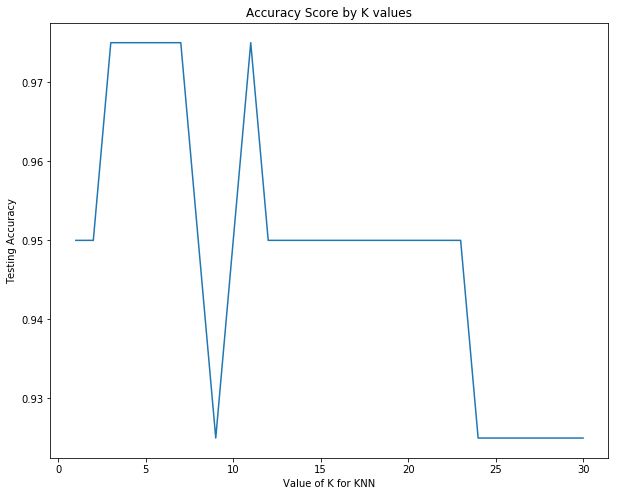

In [12]:
def plot_scores(x,y):
    fig, a = plt.subplots(1, figsize = (10, 8))
    title = "Accuracy Score by K values"
    plt.title(title)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Testing Accuracy')
    a.plot(x, y)
    
plot_scores(list(k_range), scores_list)

# 6.3 Treinando o modelo com k de maior acurácia

In [13]:
k = max(scores, key= scores.get)
print(k)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(y_pred)
metrics.accuracy_score(y_test,y_pred)

3
[0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]


0.975

In [14]:
from sklearn.decomposition import PCA
import pylab

[0.94763126 0.03191968]
[0.93602806 0.03957216]


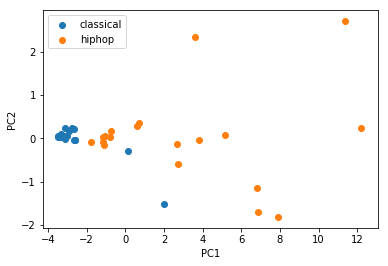

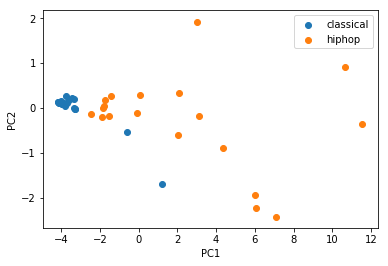

In [15]:
pca1 = PCA(2)
trans_pca1 = pca1.fit_transform(X_test)
print(pca1.explained_variance_ratio_)

pca2 = PCA(2)
pca2.fit(X_train)
trans_pca2 = pca2.transform(X_test)
print(pca2.explained_variance_ratio_)


for i, _ in enumerate(GENRES):
    pylab.scatter(trans_pca1[:,0][y_test==i], trans_pca1[:,1][y_test==i],cmap='jet',label=GENRES[i])
pylab.xlabel("PC1")
pylab.ylabel("PC2")
pylab.legend()
pylab.show()

for i, _ in enumerate(GENRES):
    pylab.scatter(trans_pca2[:,0][y_test==i], trans_pca2[:,1][y_test==i],cmap='jet',label=GENRES[i])
pylab.xlabel("PC1")
pylab.ylabel("PC2")
pylab.legend()
pylab.show()




E se utilizar o PCA no modelo de predição?

In [16]:
pca = PCA(2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(y_pred)
metrics.accuracy_score(y_test,y_pred)

[0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]


0.95

In [17]:
import seaborn as sns

In [18]:
trans_pca1 = pd.DataFrame(trans_pca1)
trans_pca1['Genres'] = [g for y in y_test for i, g in enumerate(GENRES) if y==i]
trans_pca1.columns = ['PC1', 'PC2', 'Genres']
trans_pca1.head()


,PC1,PC2,Genres
0,-3.161318,0.020871,classical
1,0.140150,-0.302802,classical
2,-3.269721,0.041713,classical
3,3.585399,2.338336,hiphop
4,12.216060,0.241604,hiphop


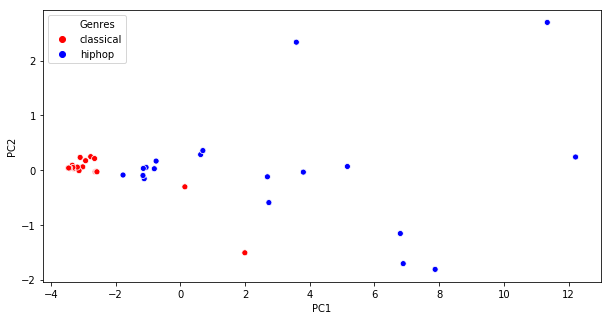

In [19]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=trans_pca1['PC1'], y=trans_pca1['PC2'], hue=trans_pca1['Genres'], palette=['red','blue'])